In [72]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

class RBF(nn.Module):
    def __init__(self, timelag):
        super(RBF, self).__init__()
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        torch.cuda.manual_seed(0)
        self.cause_clt = self.init_clt()
        self.cause_std = self.init_std()
        self.timelag = timelag
        self.init_weight_target = nn.Parameter(torch.rand(self.timelag, device=device))
        self.b = nn.Parameter(torch.rand(1, device = device))
        
    def init_clt(self):
        return nn.Parameter(torch.rand(1, device=device))

    def init_std(self):
        return nn.Parameter(torch.rand(1, device=device))
    
    def rbf(self, x, cluster, std):
        return torch.exp(-(x - cluster) * (x - cluster) / 2 * (std * std))
    
    def rbf_gradient(self, x, clt, std):
        return (-2 * (x - clt) / (std * std)) * (torch.exp(-(x - clt) * (x - clt) / 2 * (std * std)))
    
    def rbf_num_grad(self, x):
        
        rbf_grad_list = []
        for j in range(x - 2):
            rbf_grad_list.append(self.rbf(j + 2, self.cause_clt, self.cause_std) - self.rbf(j, self.cause_clt, self.cause_std))
          
        return rbf_grad_list
    
    def rbf_grad(self, x):
        
        # 1~ x.shape[0]-2th gradient list
        
        rbf_grad_list = []

        for j in range(x - 2):
            rbf_grad_list.append(self.rbf_gradient(j + 1, self.cause_clt, self.cause_std))
        
        return rbf_grad_list
    
    
    def forward(self, t):
        for i in range(t):
            if i == 0:
                a = self.rbf(i, self.cause_clt, self.cause_std)
            else:
                a = torch.cat([a, self.rbf(i, self.cause_clt, self.cause_std)], dim=0)
        
        pred = sum(a.T * self.init_weight_target) + self.b
                
        return a, pred

In [78]:

def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params
        
def train_rbf(model,X ,Y, lr, epochs, lookback=5,device = device):

    model.to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss_list = []

    best_it = None
    best_model = None
    best_loss = np.inf
    
    
    for epoch in range(epochs):
        loss_ = 0
        a_list = []
        pred_list = []
        for i in range(len(X)):
            # pred loss
            a, pred = model(len(X[i]))
            a_list.append(a)
            pred_list.append(pred)
            loss_ += loss_fn(pred, Y[i])

            # rbf_num_list = model.rbf_num_grad(len(Y))
            # rbf_fn_grad = model.rbf_grad(len(Y))

            # loss_grad = sum([loss_fn(rbf_fn_grad[j], rbf_num_list[j]) for j in range(len(rbf_num_list))])
            # if epoch % 100 == 0:
        print("epoch {} loss {} :".format(epoch, loss_ / len(Y)))
        print("------------------------------------------------------")
        print()
        
        loss_.backward()
        optimizer.step()
        model.zero_grad()
        mean_loss = loss_ / len(Y)
        train_loss_list.append(mean_loss)
        
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_it = epoch
            best_model = deepcopy(model)
            
        elif (epoch - best_it) == lookback:
            if verbose:
                print('Stopping early')
            break

    restore_parameters(model, best_model)

    return train_loss_list , model, pred_list, a_list

In [52]:
import pandas as pd
df = pd.read_csv('C:/Users/chanyoung/Desktop/Neural-GC-master/lorenz_96_10_10_1000.csv')
X2d = df[['a','b']]

In [51]:
def data_split(X, cause, target, timelag, device = device):
    input_cause = []
    input_target = []
    Y = []

    for i in range(len(X) - (timelag + 1)):
        input_cause.append(X[cause].values[i: i + timelag])
        input_target.append(X[target].values[i: i + timelag])
        Y.append([X[target][i + timelag + 1]])

    return torch.tensor(input_cause, device=device).float(), torch.tensor(input_target,device=device).float(), torch.tensor(Y, device=device).float()


In [53]:
input_cause, input_target, Y = data_split(X2d, 'a', 'a', 10)

In [65]:
init_weight_target = nn.Parameter(torch.rand(10, device=device))

In [67]:
init_weight_target

Parameter containing:
tensor([0.9345, 0.8207, 0.0164, 0.1889, 0.9616, 0.0436, 0.4849, 0.7817, 0.4673,
        0.3371], device='cuda:0', requires_grad=True)

In [70]:
0.8207 * 0.8207

0.6735484899999999

In [75]:
sum(init_weight_target.T * init_weight_target) + b

tensor([4.6222], device='cuda:0', grad_fn=<AddBackward0>)

In [74]:
b = nn.Parameter(torch.rand(1, device = device))

In [57]:
len(input_cause)

989

In [79]:
model = RBF(10)
print(model.cause_clt)
print(model.cause_std)
loss, best_model, pred = train_rbf(model, input_cause,Y, 0.01, 100, device)
print(best_model.cause_clt)
print(best_model.cause_std)

Parameter containing:
tensor([0.3990], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.9722], device='cuda:0', requires_grad=True)
epoch 0 loss 17.486648559570312 :
------------------------------------------------------

epoch 1 loss 17.396259307861328 :
------------------------------------------------------

epoch 2 loss 17.31011199951172 :
------------------------------------------------------

epoch 3 loss 17.228439331054688 :
------------------------------------------------------

epoch 4 loss 17.151487350463867 :
------------------------------------------------------

epoch 5 loss 17.079526901245117 :
------------------------------------------------------

epoch 6 loss 17.01278305053711 :
------------------------------------------------------

epoch 7 loss 16.95144271850586 :
------------------------------------------------------

epoch 8 loss 16.89580535888672 :
------------------------------------------------------

epoch 9 loss 16.84593963623047 :
---------

epoch 89 loss 16.6540584564209 :
------------------------------------------------------

epoch 90 loss 16.654043197631836 :
------------------------------------------------------

epoch 91 loss 16.654033660888672 :
------------------------------------------------------

epoch 92 loss 16.65404510498047 :
------------------------------------------------------

epoch 93 loss 16.654033660888672 :
------------------------------------------------------

epoch 94 loss 16.654024124145508 :
------------------------------------------------------

epoch 95 loss 16.65402603149414 :
------------------------------------------------------

epoch 96 loss 16.65401840209961 :
------------------------------------------------------

epoch 97 loss 16.654008865356445 :
------------------------------------------------------

epoch 98 loss 16.65398597717285 :
------------------------------------------------------

epoch 99 loss 16.65399742126465 :
------------------------------------------------------



ValueError: too many values to unpack (expected 3)

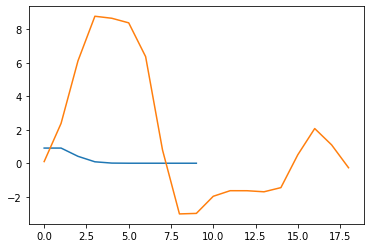

In [48]:
import matplotlib.pyplot as plt

plt.plot(pred[:19].cpu().detach().numpy())
plt.plot(a[:19].cpu().detach().numpy())
plt.show()